## WCF Modelling

This code:

- Import a CSV and create a random forest model
- Choose a location and download some satellite data
- Apply model to satellite image
- Do some plotting

#### Questions and things to do

- Why is the data in the geomedian orders larger than the data in the csv?
    - I think the geomedian is in DNs and the training data is SR?
- What is the threshold for woody / not woody?
    - If it measures how woody, everything over 0 is woody?
- Fiddle with the random forest parameters
- Should I transform the inputs to be gaussian?

#### Other things to consider

- WCF saturates above 0.6

#### Sources of error

- Since WCF is derived from single-date LiDAR data and an annual geomedian is being used to predict it the geomedian may not represent the same vegetation as was present when LiDAR was acquired.
- Mixed pixels containing water and vegetation tended to overestimate WCF.
- Vegetation lower than 2m (e.g. dense shrubland or new plantations) could have a WCF from Landsat, although LiDAR would not have.

LiDAR
- Variation in pulse density (4 to 8 ppm)
- Variation in achieved density returns (4 to 20 ppm)

WCF derived from LiDAR was suprisingly low
- possibly due to attribution of VCF to height, and only above 2m is considered in WCF
- identifying points in LiDAR waveform is more challenging over dense uniform forest

Overall systematic underestimation of true cover at high values



#### Import modules

In [23]:
%matplotlib inline

import sys
import pandas as pd
import datacube
import matplotlib.pyplot as plt

sys.path.append("../Scripts")
from datacube.helpers import write_geotiff
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs
from dea_plotting import display_map
from dea_plotting import rgb
from dea_classificationtools import predict_xr
from dea_classificationtools import sklearn_unflatten
from dea_classificationtools import sklearn_flatten

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import metrics

import numpy as np
import xarray as xr
from sklearn.model_selection import GridSearchCV
import pickle

In [2]:
dc = datacube.Datacube(app='Alberts Forest')

#### Import training data csv

In [3]:
path = 'WCF_traindata_14122019.csv'
df = pd.read_csv(path)
df.head()

,WCF,blue,green,red,nir,swir1,swir2
0,0.680150,0.024840,0.038088,0.041936,0.20717,0.11010,0.062355
1,0.408790,0.043154,0.063489,0.069489,0.22708,0.17888,0.115670
2,0.000004,0.034636,0.064774,0.063311,0.32425,0.21022,0.111040
3,0.216960,0.032932,0.046541,0.050958,0.18029,0.17601,0.108140
4,0.434480,0.030078,0.046560,0.047636,0.20356,0.12678,0.073669


(array([3.6500e+02, 3.5900e+03, 1.0193e+04, 4.4710e+03, 3.0120e+03,
        3.2690e+03, 2.4770e+03, 2.5370e+03, 2.2850e+03, 2.1010e+03,
        1.8160e+03, 1.5520e+03, 1.5340e+03, 8.4900e+02, 3.1400e+02,
        1.2200e+02, 9.6000e+01, 7.7000e+01, 4.9000e+01, 5.5000e+01,
        4.0000e+01, 2.9000e+01, 3.3000e+01, 1.8000e+01, 1.2000e+01,
        1.9000e+01, 1.1000e+01, 3.0000e+00, 6.0000e+00, 3.0000e+00]),
 array([-0.00074808,  0.01537486,  0.03149779,  0.04762073,  0.06374366,
         0.0798666 ,  0.09598954,  0.11211247,  0.12823541,  0.14435834,
         0.16048128,  0.17660422,  0.19272715,  0.20885009,  0.22497302,
         0.24109596,  0.2572189 ,  0.27334183,  0.28946477,  0.3055877 ,
         0.32171064,  0.33783358,  0.35395651,  0.37007945,  0.38620238,
         0.40232532,  0.41844826,  0.43457119,  0.45069413,  0.46681706,
         0.48294   ]),
 <a list of 30 Patch objects>)

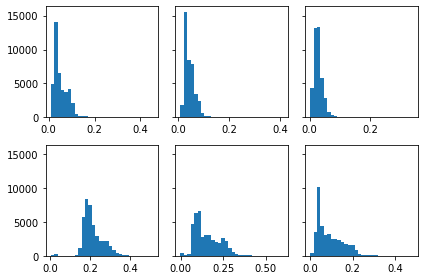

In [4]:
fig, axs = plt.subplots(2, 3, sharey=True, tight_layout=True)
axs[0,0].hist(df[' red'],bins=30)
axs[0,1].hist(df[' green'],bins=30)
axs[0,2].hist(df['blue'],bins=30)
axs[1,0].hist(df[' nir'],bins=30)
axs[1,1].hist(df[' swir1'],bins=30)
axs[1,2].hist(df[' swir2'],bins=30)

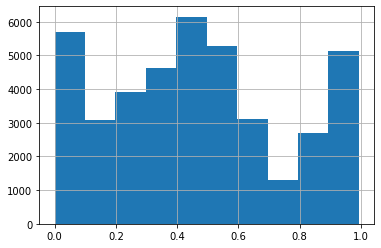

In [5]:
# Plot a histogram of WCF values
df['WCF'].hist()

#### Create and evaluate model

https://www.youtube.com/watch?v=YYjvkSJoui4 

In [7]:
# Handle misisng data
df = df.dropna()

# Define dependent variable
Y = df['WCF']

# Define independent variables
X = df.drop(labels=['WCF'],axis=1)

# Split model into testing and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

# Define model
model = RandomForestRegressor(n_estimators=100, # number of trees in forest, is this equal to ensemble?
                              #criterion = 'mse', # function to measure the quality of the split
                              #max_depth = None, # max depth of tree. If None, then nodes are expanded until all laves are pure, or until all leaves contain less than min_samples_split
                              min_samples_split = 2, # Min no. samples required to be at a split node 
                              min_samples_leaf = 50, # Min no. samples required to be at a leaf node 
                              #min_weight_fraction_leaf = 0, # The min weighted fraction. Samples have equal weight when 0.
                              #max_features = 'auto', # The number of features to consider when looking for the best split
                              #max_leaf_nodes = None, # If None, then unlimited number of leaf nodes
                              #min_impurity_decrease = 0, # Split nodes to decrease impurity
                              #min_impurity_split = 1e-7, # Replaced by min_impurity_decrease
                              #bootstrap = true, # Whether to bootstrap samples when building trees. If False, the whole dataset is used ot build each tree.
                              #oob_score = False, # Whether to use out-of-bag samples to estimate R^2 on unseen data
                              #n_jobs = None, # The number of jobs to run in parallel. None means 1
                              random_state=30, # Controls the randomness of bootstrapping and the sampling of features to consider for bets node split
                              #verbose = 0, # Controls the verbosity when fititng and predicting
                              #warm_start = False, # False - fit new forest, True - reuse solution from previous call amd add more estimators to ensemble
                              #ccp_alpha = 0.0, # Complexity parameter
                              #max_samples = None, # If bootstrap is True, the numbe rof samples to draw from X to train each base estimator
                             )

# Fit model
model.fit(X_train,Y_train)

# Predict test data
prediction_test = model.predict(X_test)

In [8]:
X_train.head()

,blue,green,red,nir,swir1,swir2
15659,0.029332,0.044725,0.051168,0.18150,0.154330,0.094460
15644,0.041128,0.078211,0.076077,0.37090,0.268270,0.160590
20255,0.032936,0.058935,0.098673,0.16574,0.217840,0.185850
39841,0.025500,0.030995,0.029067,0.17310,0.099446,0.045347
7415,0.027389,0.043515,0.045561,0.20521,0.157140,0.086316


In [9]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 50,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 30,
 'verbose': 0,
 'warm_start': False}

#### Performance metrics

In draft:
- Root mean square estimate (RMSE) = 0.061
- Coefficient of determination (R^2) = 0.862
- Nash-Sutcliffe model efficiency (ME) = 0.862

In [10]:
# Metrics
print('Explained variance score = ')
print(metrics.explained_variance_score(Y_test, prediction_test)) # what measure to use https://scikit-learn.org/stable/modules/model_evaluation.html
print('R^2 =')
print(metrics.r2_score(Y_test, prediction_test))
print('RMSE =')
print(metrics.mean_squared_error(Y_test, prediction_test))

Explained variance score = 
0.9246561500356675
R^2 =
0.9246331026823922
RMSE =
0.0062849142408366344


In [ ]:
Y_test

In [ ]:
plt.scatter(Y_test, prediction_test)

In [ ]:
fig, axs = plt.subplots(2, 3, sharey=True, tight_layout=True)
axs[0,0].scatter(df[' red'],df['WCF'])
axs[0,1].scatter(df[' green'],df['WCF'])
axs[0,2].scatter(df['blue'],df['WCF'])
axs[1,0].scatter(df[' nir'],df['WCF'])
axs[1,1].scatter(df[' swir1'],df['WCF'])
axs[1,2].scatter(df[' swir2'],df['WCF'])

#### Order of importance



nir, blue, swir1, green, swir2, red

In [ ]:
# Determine the importance of each of the bands
#print(model.feature_importances_) # need to format nicely
feature_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
print(feature_imp)

## Hyperparameter tuning with:
1. Randomized Search CV
2. Grid Search CV

In [ ]:
# Create a blank model
model_cv = RandomForestRegressor(n_jobs=-1, verbose=0)

# View the hyperparameters
print(model_cv.get_params())

## Explore parameter tuning with Randomized Search CV

#### Set up the grid for use in the randomised search

In [ ]:
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']

# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 100, num = 11)]
# max_depth.append(None)

# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]

# max_leaf_nodes = [20, 25, 30, 35, 40]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]

Variables to use in the grid:

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 40, stop = 300, num = 20)]

# Minimum number of samples required at each leaf
min_samples_leaf = [1, 10, 30, 50, 75, 100]

# Random state
random_state = [None, 0, 10, 20, 30]

Create the grid:

In [ ]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               #'max_features': max_features,
               #'max_depth': max_depth,
               #'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'random_state':random_state
               #'bootstrap': bootstrap
              }
print(random_grid)

#### Run the randomised search

This may take a while... 
(20 takes about 8 minutes)

In [ ]:
rscv_model = RandomizedSearchCV(estimator = model_cv, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rscv_results = rscv_model.fit(X_train, Y_train)

#### See the relative importance of variables

In [ ]:
model_variables = ['blue', ' green', ' red', ' nir', ' swir1', ' swir2']

# Variable importance
for var_name, var_importance in zip(model_variables, rscv_results.best_estimator_.feature_importances_):
    print("{}: {:.04}".format(var_name, var_importance))

#### From the randomised search find the best parameter values to use

In [ ]:
# Print best parameter values
rscv_results.best_estimator_

#### Create an improved model using the best parameter values
Copy best_estimator_ parameters into the code below

In [11]:
# Create an instance of the model
improved_model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=28, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=163, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

# Fit the model
improved_model.fit(X_train,Y_train)

# Predict Y from X_test
pt = improved_model.predict(X_test)

# Print the R2
metrics.r2_score(Y_test,pt)

0.9408491152269763

## Detailed parameter tuning with Grid Search CV

#### Set up the grid for use in the grid search

In [ ]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'min_samples_leaf': [1, 30, 60],
    'random_state':[None,0,30]
}

#### Run the grid search

This may take a while... 
(37 tasks takes about 5.5 minutes)

In [ ]:
grid_model = GridSearchCV(estimator = model_cv, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1)
grid_results = grid_model.fit(X_train, Y_train)

#### From the randomised search find the best parameter values to use

In [ ]:
print(grid_results.best_estimator_)

#### Create an improved model using the best parameter values
Copy best_estimator_ parameters into the code below

In [12]:
# Create an instance of the model
improved_grid_model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

# Fit the model
improved_grid_model.fit(X_train,Y_train)

# Predict Y from X_test
grid_pt = improved_grid_model.predict(X_test)

# Print the R2
metrics.r2_score(Y_test,grid_pt)

0.9421853567976651

#### Do some pickling

In [ ]:
# # Pickle this model
# pickle_out = open('pickled.pickle','wb')
# pickle.dump(improved_grid_model,pickle_out)
# pickle_out.close()

In [ ]:
# pickle_in = open('pickled.pickle','rb')
# improved_grid_model = pickle.load(pickle_in)
# print(improved_grid_model)

## Apply the model to an image

### Choose location

When models were made for individual locations the performance varied significantly in Albert's data:

- Whroo in Victoria have an R^2 of only 0.35 (-36.703137, 145.035462)
- ACT had an R^2 of 0.87 (-35.434967, 149.002428)

Use custom area of interest:

In [13]:
# Set the central latitude and longitude
central_lat = -35.434967
central_lon = 149.002428

# Set the buffer to load around the central coordinates
buffer = 0.1

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


Use LCCS test areas:

In [14]:
# # Ayr
# x = (1500000, 1600000) # EPSG:3577 to lat lons
# y = (-2200000, -2100000)
# min_x = 1500000
# max_x = 1600000
# min_y = -2200000
# max_y = -2100000
# res_x = 100
# res_y = -100

# # Display an interactive map
# display_map(x=x, y=y, crs='EPSG:3577', margin=-0.2) 

### Load in image

In [94]:
start_date = '2010'
end_date = start_date 

#Load all data in baseline period available from Near Real Time data

image = dc.load(
              product=['ls8_nbart_geomedian_annual', 'ls5_nbart_geomedian_annual'],
              x=study_area_lon, #study_area_lon or x
              y=study_area_lat, #study_area_lat or y
              time=(start_date, end_date),
              #measurements=['nbar_blue','nbar_green','nbar_red','nbar_nir_1', 'nbar_swir_3'],
              output_crs='EPSG:3577',
              #crs='EPSG:3577',
              resolution=(-10, 10),
              #group_by='solar_day'
)
image

<xarray.Dataset>
Dimensions:  (time: 1, x: 2093, y: 2444)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01
  * y        (y) float64 -3.961e+06 -3.961e+06 ... -3.985e+06 -3.985e+06
  * x        (x) float64 1.526e+06 1.526e+06 1.526e+06 ... 1.547e+06 1.547e+06
Data variables:
    blue     (time, y, x) int16 455 455 467 467 467 461 ... 552 552 511 511 466
    green    (time, y, x) int16 790 790 783 783 783 757 ... 834 834 779 779 690
    red      (time, y, x) int16 866 866 839 839 839 782 ... 904 904 850 850 745
    nir      (time, y, x) int16 2389 2389 2443 2443 2443 ... 2430 2385 2385 2301
    swir1    (time, y, x) int16 2667 2667 2630 2630 2630 ... 2951 3016 3016 2794
    swir2    (time, y, x) int16 1605 1605 1557 1557 1557 ... 1729 1686 1686 1553
Attributes:
    crs:      EPSG:3577

### Predict WCF on image

In [59]:
# Prepare dataset to go in the model
flat = sklearn_flatten(image)
flat = flat/10000

# Run to model
results = improved_grid_model.predict(flat)

# Unflatten the results
unflat = (sklearn_unflatten(results,image).transpose())[0]

unflat

<xarray.DataArray (y: 2444, x: 2093)>
array([[0.01591128, 0.01591128, 0.02129551, ..., 0.20760943, 0.20760943,
        0.24748558],
       [0.01591128, 0.01591128, 0.02129551, ..., 0.20760943, 0.20760943,
        0.24748558],
       [0.17797217, 0.17797217, 0.14848766, ..., 0.14120339, 0.14120339,
        0.15678682],
       ...,
       [0.36862966, 0.36862966, 0.34241689, ..., 0.01888327, 0.01888327,
        0.04582725],
       [0.38332638, 0.38332638, 0.41681743, ..., 0.02509245, 0.02509245,
        0.07487338],
       [0.38332638, 0.38332638, 0.41681743, ..., 0.02509245, 0.02509245,
        0.07487338]])
Coordinates:
  * x        (x) float64 1.526e+06 1.526e+06 1.526e+06 ... 1.547e+06 1.547e+06
  * y        (y) float64 -3.961e+06 -3.961e+06 ... -3.985e+06 -3.985e+06
    time     datetime64[ns] 2010-01-01

### Plot the results

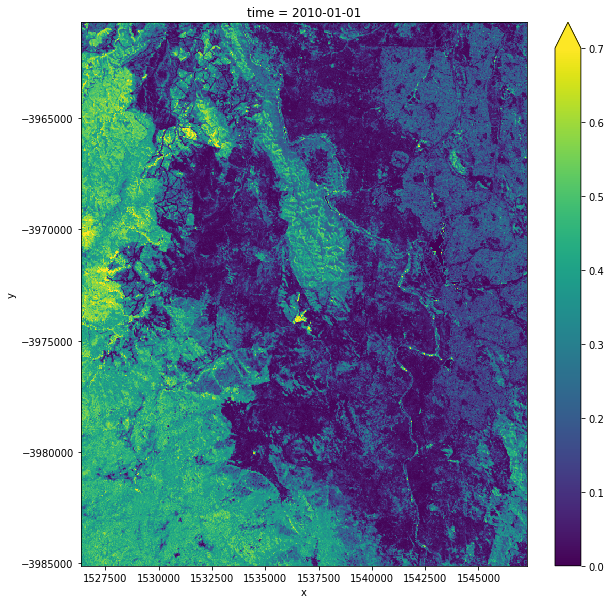

In [60]:
# Woody cover in training data varies between 0 and 0.75
unflat.plot(figsize=(10,10),vmin=0,vmax=0.7)

(array([ 6872.,   939.,   782.,   714.,   707.,   818.,  1112.,  1273.,
         1866.,  2287.,  2825.,  3544.,  4322.,  5144.,  5792.,  7272.,
         7375.,  8264.,  9280.,  9727., 10515., 11402., 11990., 12393.,
        12549., 12437., 13061., 13647., 13606., 13703., 14915., 15018.,
        14244., 14487., 14557., 14724., 14818., 15941., 15403., 15564.,
        15352., 15717., 15480., 16133., 16224., 15580., 16570., 16133.,
        15970., 16210., 16318., 15581., 15516., 15817., 15832., 15198.,
        15542., 15238., 15095., 15439., 15131., 15059., 14507., 14818.,
        14779., 14369., 14535., 14253., 14342., 13889., 14369., 13967.,
        13640., 13918., 13425., 13436., 12864., 12985., 12755., 12256.,
        11876., 12206., 11964., 11327., 11444., 12195., 11542., 11232.,
        11218., 11376., 11248., 10197., 10434., 10874., 10509., 10418.,
        10260., 10324., 10261., 10236.]),
 array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
        0.004 , 0.0045

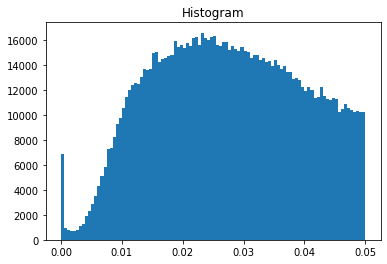

In [61]:
xr.plot.hist(unflat,bins=100,range=(0,0.05))

#### Apply a threshold

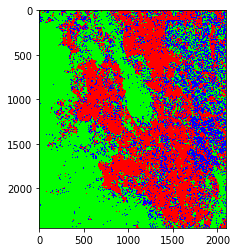

In [41]:
not_woody = unflat<=0.1
woody = np.logical_and(unflat>0.1,unflat<=0.2)
very_woody = unflat>0.2

#We use this numpy function to stack 2-dimensional arrays over the 3rd axis or depth:
classes= np.dstack((not_woody,very_woody,woody)).astype(np.uint8) * 255

plt.imshow(classes)

In [42]:
# Constants for calculating burnt area
resolution = (-30,30)
pixel_length = resolution[1] # in metres
#print(pixel_length)
m_per_km = 1000 # conversion from metres to kilometres

# Area per pixel
area_per_pixel = pixel_length**2/m_per_km**2
#print(area_per_pixel)

# Calculate areas
not_woody_area = np.sum(not_woody.values)*area_per_pixel
woody_area = np.sum(woody.values)*area_per_pixel
very_woody_area = np.sum(very_woody.values)*area_per_pixel

print('Not woody:  ',not_woody_area)
print('Woody:      ',woody_area)
print('Very woody: ',very_woody_area)

Not woody:   1648.9188
Woody:       874.3446
Very woody:  2080.4994


In [43]:
# Mask
masked = baseline_da.where(unflat>0.1)
rgb(masked, bands=['red', 'green', 'blue'],size=10)

# Visualise median image as true colour image
rgb(baseline_da, bands=['red', 'green', 'blue'],size=10)

NameError: name 'baseline_da' is not defined

### Save results to Geotiff
To save results to geotiff for use and analysis in GIS software packages un comment the following Write_geotiff comands.

In [73]:
image.to_array

<bound method Dataset.to_array of <xarray.Dataset>
Dimensions:  (time: 1, x: 2093, y: 2444)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01
  * y        (y) float64 -3.961e+06 -3.961e+06 ... -3.985e+06 -3.985e+06
  * x        (x) float64 1.526e+06 1.526e+06 1.526e+06 ... 1.547e+06 1.547e+06
Data variables:
    blue     (time, y, x) int16 455 455 467 467 467 461 ... 552 552 511 511 466
    green    (time, y, x) int16 790 790 783 783 783 757 ... 834 834 779 779 690
    red      (time, y, x) int16 866 866 839 839 839 782 ... 904 904 850 850 745
    nir      (time, y, x) int16 2389 2389 2443 2443 2443 ... 2430 2385 2385 2301
    swir1    (time, y, x) int16 2667 2667 2630 2630 2630 ... 2951 3016 3016 2794
    swir2    (time, y, x) int16 1605 1605 1557 1557 1557 ... 1729 1686 1686 1553
Attributes:
    crs:      EPSG:3577>

In [68]:
# Turn delta NBR into a Xarray Dataset for export to geotiff
dataset = unflat.to_dataset(name='wcf_example').assign_attrs({'crs': 'EPSG:3577'})
write_geotiff(start_date+'_wcf_example.tif', dataset)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [95]:
image = image.isel(time=0)

In [96]:
write_geotiff(start_date+'_geomedian.tif', image)